In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from lane_lines import LaneLines


test_images/test6.jpg


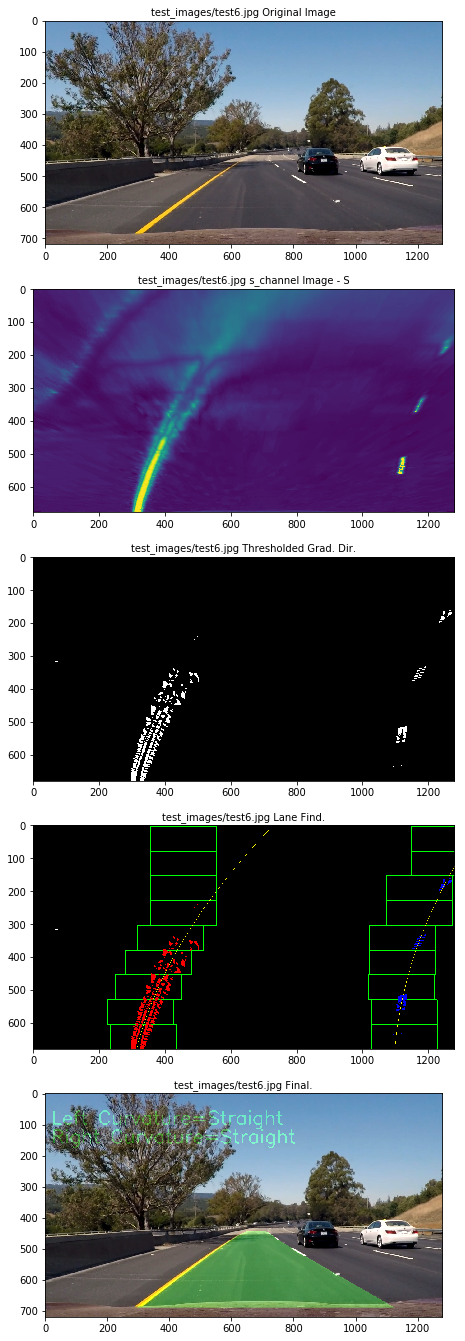

In [2]:
lanes = LaneLines('camera_cal')
for file in glob.glob('test_images/*test*.jpg'):
    print (file)
    img = mpimg.imread(file)
    final = lanes.process_image(img)
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(20, 20))

    ax1.imshow(img)
    ax1.set_title(file + ' Original Image', fontsize=10)

    ax2.imshow(lanes.source_channel)
    ax2.set_title(file + ' s_channel Image - S', fontsize=10)

    ax3.imshow(lanes.binary_warped, cmap='gray')
    ax3.set_title(file + ' Thresholded Grad. Dir.', fontsize=10)

    ax4.imshow(lanes.lane_find_visualization)
    ax4.set_title(file + ' Lane Find.', fontsize=10)

    ax5.imshow(final)
    ax5.set_title(file + ' Final.', fontsize=10)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    break
    

In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lanes = LaneLines('camera_cal')

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lanes.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:10<00:00,  6.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 10min 9s, sys: 2.54 s, total: 10min 12s
Wall time: 3min 11s
